In [2]:
import datetime
import json
import pandas as pd 
from pathlib import Path
import os 
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

from IPython.core.pylabtools import figsize


# Loading data

In [3]:
df = pd.read_csv("combined_50csv.csv", low_memory=True)
df['author_id'] = df['author_id'].astype(str)
subset = pd.read_csv("subset_1.csv") #122263
subset['author_id'] = subset['author_id'].astype(str)
subset['in_reply_to_user_id'] = subset['in_reply_to_user_id'].round().astype('Int64').astype(str)
# filter rows in subset where in_reply_to_user_id has at least one real estate tweet in the main sample (ie in_reply_to_user_id is at least one author id in main sample)
subset = subset[subset['in_reply_to_user_id'].isin(df['author_id'])] 

print(subset['in_reply_to_user_id'].nunique()) #17132
# author_username is a column that takes authorid if author.username is NaN
subset['author_username'] = subset['author.username'].fillna(subset['author_id'])
subset['in_reply_to_username1'] = subset['in_reply_to_username'].fillna(subset['in_reply_to_user_id'])

/users/phd/mcheah/.pyenv/versions/3.7.0/envs/twitterenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (11,27,28,29,31,34,35,36,37,39,41,42,43,49,65,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/users/phd/mcheah/.pyenv/versions/3.7.0/envs/twitterenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (29,30,40,42,43,44,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


17132


In [4]:

# Group by 'in_reply_to_user_id' and aggregate data
x = subset.groupby('in_reply_to_user_id').agg({
    'author.public_metrics.followers_count': 'mean', 
    'in_reply_to_username': 'first'  # Keeps the first username for each group
})

# Reset index to make 'in_reply_to_user_id' a column again
x = x.reset_index()
x['in_reply_to_user_id'] = x['in_reply_to_user_id'].astype(str)

df2 = pd.read_csv("filtered_data/alltweetsrelatedtonetwork.csv")
df2['author_id'] = df2['author_id'].astype(str)

#find out how many tweets of influencers in the main filtered sample 
nodes = df2[df2['author_id'].isin(x['in_reply_to_user_id'])]
responders = df2[~df2['author_id'].isin(x['in_reply_to_user_id'])]

print(len(nodes))
print(len(responders))


/users/phd/mcheah/.pyenv/versions/3.7.0/envs/twitterenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (12,29,30,32,35,36,37,38,40,42,43,44,50,68,69,70,71,72,73,74,75,76,77,78,79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1094664
153858


# Descriptive Statistics

In [5]:
# Calculate the statistics for both columns
nodes_stats = nodes.drop_duplicates(subset='author_id')['author.public_metrics.followers_count'].describe(percentiles=[.25, .5, .75, 0.9, .99])
responders_stats = responders.drop_duplicates(subset='author_id')['author.public_metrics.followers_count'].describe(percentiles=[.25, .5, .75, 0.9, .99])

# Create a new DataFrame with these statistics
statistics_df = pd.DataFrame({
    'nodes_followers_counts': nodes_stats,
    'responders_followers_count': responders_stats
})

# Select only the rows you want (mean, std, 25th, 50th, 75th, 90th, 99th percentiles)
selected_rows = ['mean', 'std', '25%', '50%', '75%', '90%', '99%']
statistics_df = statistics_df.loc[selected_rows]

statistics_df = statistics_df.round().astype(int)

print(statistics_df)


      nodes_followers_counts  responders_followers_count
mean                  126282                        2384
std                  1227458                       14780
25%                     1131                         117
50%                     4315                         423
75%                    23128                        1446
90%                   122426                        4061
99%                  2020818                       31195


In [35]:
# Group by 'in_reply_to_user_id' and aggregate data
in_degree_counts = subset.groupby('in_reply_to_user_id').agg({
    'author_id': pd.Series.nunique, 
    'in_reply_to_username': 'first' # Keeps the first username for each group
})

# Rename columns for clarity
in_degree_counts.rename(columns={'author_id': 'unique_authors_count'}, inplace=True)
# Sort the DataFrame based on 'unique_authors_count' in descending order
in_degree_counts = in_degree_counts.sort_values(by='unique_authors_count', ascending=False)


In [36]:
len(subset)

39399

# Graph Showing Number of In-Degree Connections for the Influencers

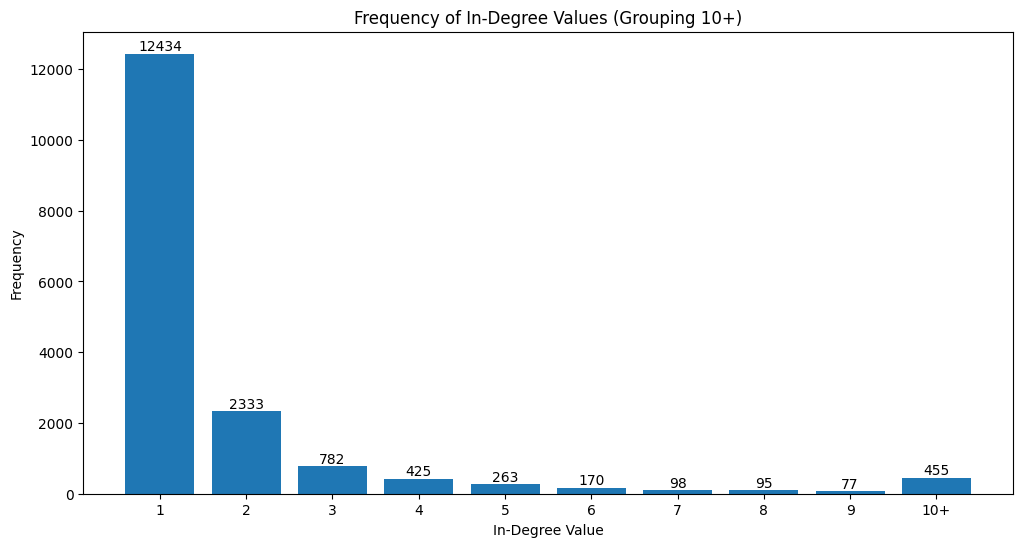

In [7]:
#  Create "in_degree_counts" csv
# Filter out rows where a user replies to their own tweet
filtered_replies = subset[subset['author_id'] != subset['in_reply_to_user_id']]

# Group by 'in_reply_to_user_id' and count unique 'author_id's for each group
in_degree_counts = filtered_replies.groupby('in_reply_to_user_id')['author_id'].nunique()

# Merge the results back into the original DataFrame
filtered_replies = filtered_replies.merge(in_degree_counts.rename('in_degree'), left_on='in_reply_to_user_id', right_index=True)
filtered_replies = filtered_replies.drop_duplicates(subset = 'in_reply_to_user_id', keep = 'first')

# test = filtered_replies[['in_reply_to_user_id','in_degree']]
# test = test.rename(columns={'in_reply_to_user_id': 'Node', 'in_degree':'In_degree'})
# test.head()
# test.to_csv("centrality_rank/in_degree_counts_fixed.csv")


# Create distribution of in-degree values of influencers on page 14

# Sort and filter as before
in_degree_less_than_10 = filtered_replies[filtered_replies['in_degree'] < 10]['in_degree']
in_degree_10_or_more = filtered_replies[filtered_replies['in_degree'] >= 10]['in_degree']
frequency_counts_less_than_10 = in_degree_less_than_10.value_counts().sort_index()
frequency_count_10_or_more = len(in_degree_10_or_more)
combined_frequency_counts = frequency_counts_less_than_10.append(pd.Series([frequency_count_10_or_more], index=['10+']))

# Create numerical indices for x-axis
x_indices = range(len(combined_frequency_counts))

# Plotting the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(x_indices, combined_frequency_counts.values)

# Set the x-axis tick labels
plt.xticks(x_indices, combined_frequency_counts.index)

# Adding labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.title('Frequency of In-Degree Values (Grouping 10+)')
plt.xlabel('In-Degree Value')
plt.ylabel('Frequency')

plt.show()


# Summary statistics of Number of In-Degree Connections for Top 100 Influencers

In [37]:
# statistics for top 100 nodes
in_degree_counts= in_degree_counts.head(n=100)

# Calculate the mean
mean_value = in_degree_counts['unique_authors_count'].mean()
median_value = in_degree_counts['unique_authors_count'].median()
# Calculate the standard deviation
std_dev_value = in_degree_counts['unique_authors_count'].std()

# Calculate the percentiles
percentiles = in_degree_counts['unique_authors_count'].quantile([0.25, 0.5, 0.75, 0.99])

# Display the results
print("Mean:", mean_value)
print("Median", median_value)
print("Standard Deviation:", std_dev_value)
print("25th Percentile:", percentiles[0.25])
print("50th Percentile (Median):", percentiles[0.5])
print("75th Percentile:", percentiles[0.75])
print("99th Percentile:", percentiles[0.99])

Mean: 57.56
Median 44.0
Standard Deviation: 40.298462261059804
25th Percentile: 35.0
50th Percentile (Median): 44.0
75th Percentile: 64.25
99th Percentile: 186.3600000000007


# Network Graph for Top 100 Influencers and their In-Degree Connections

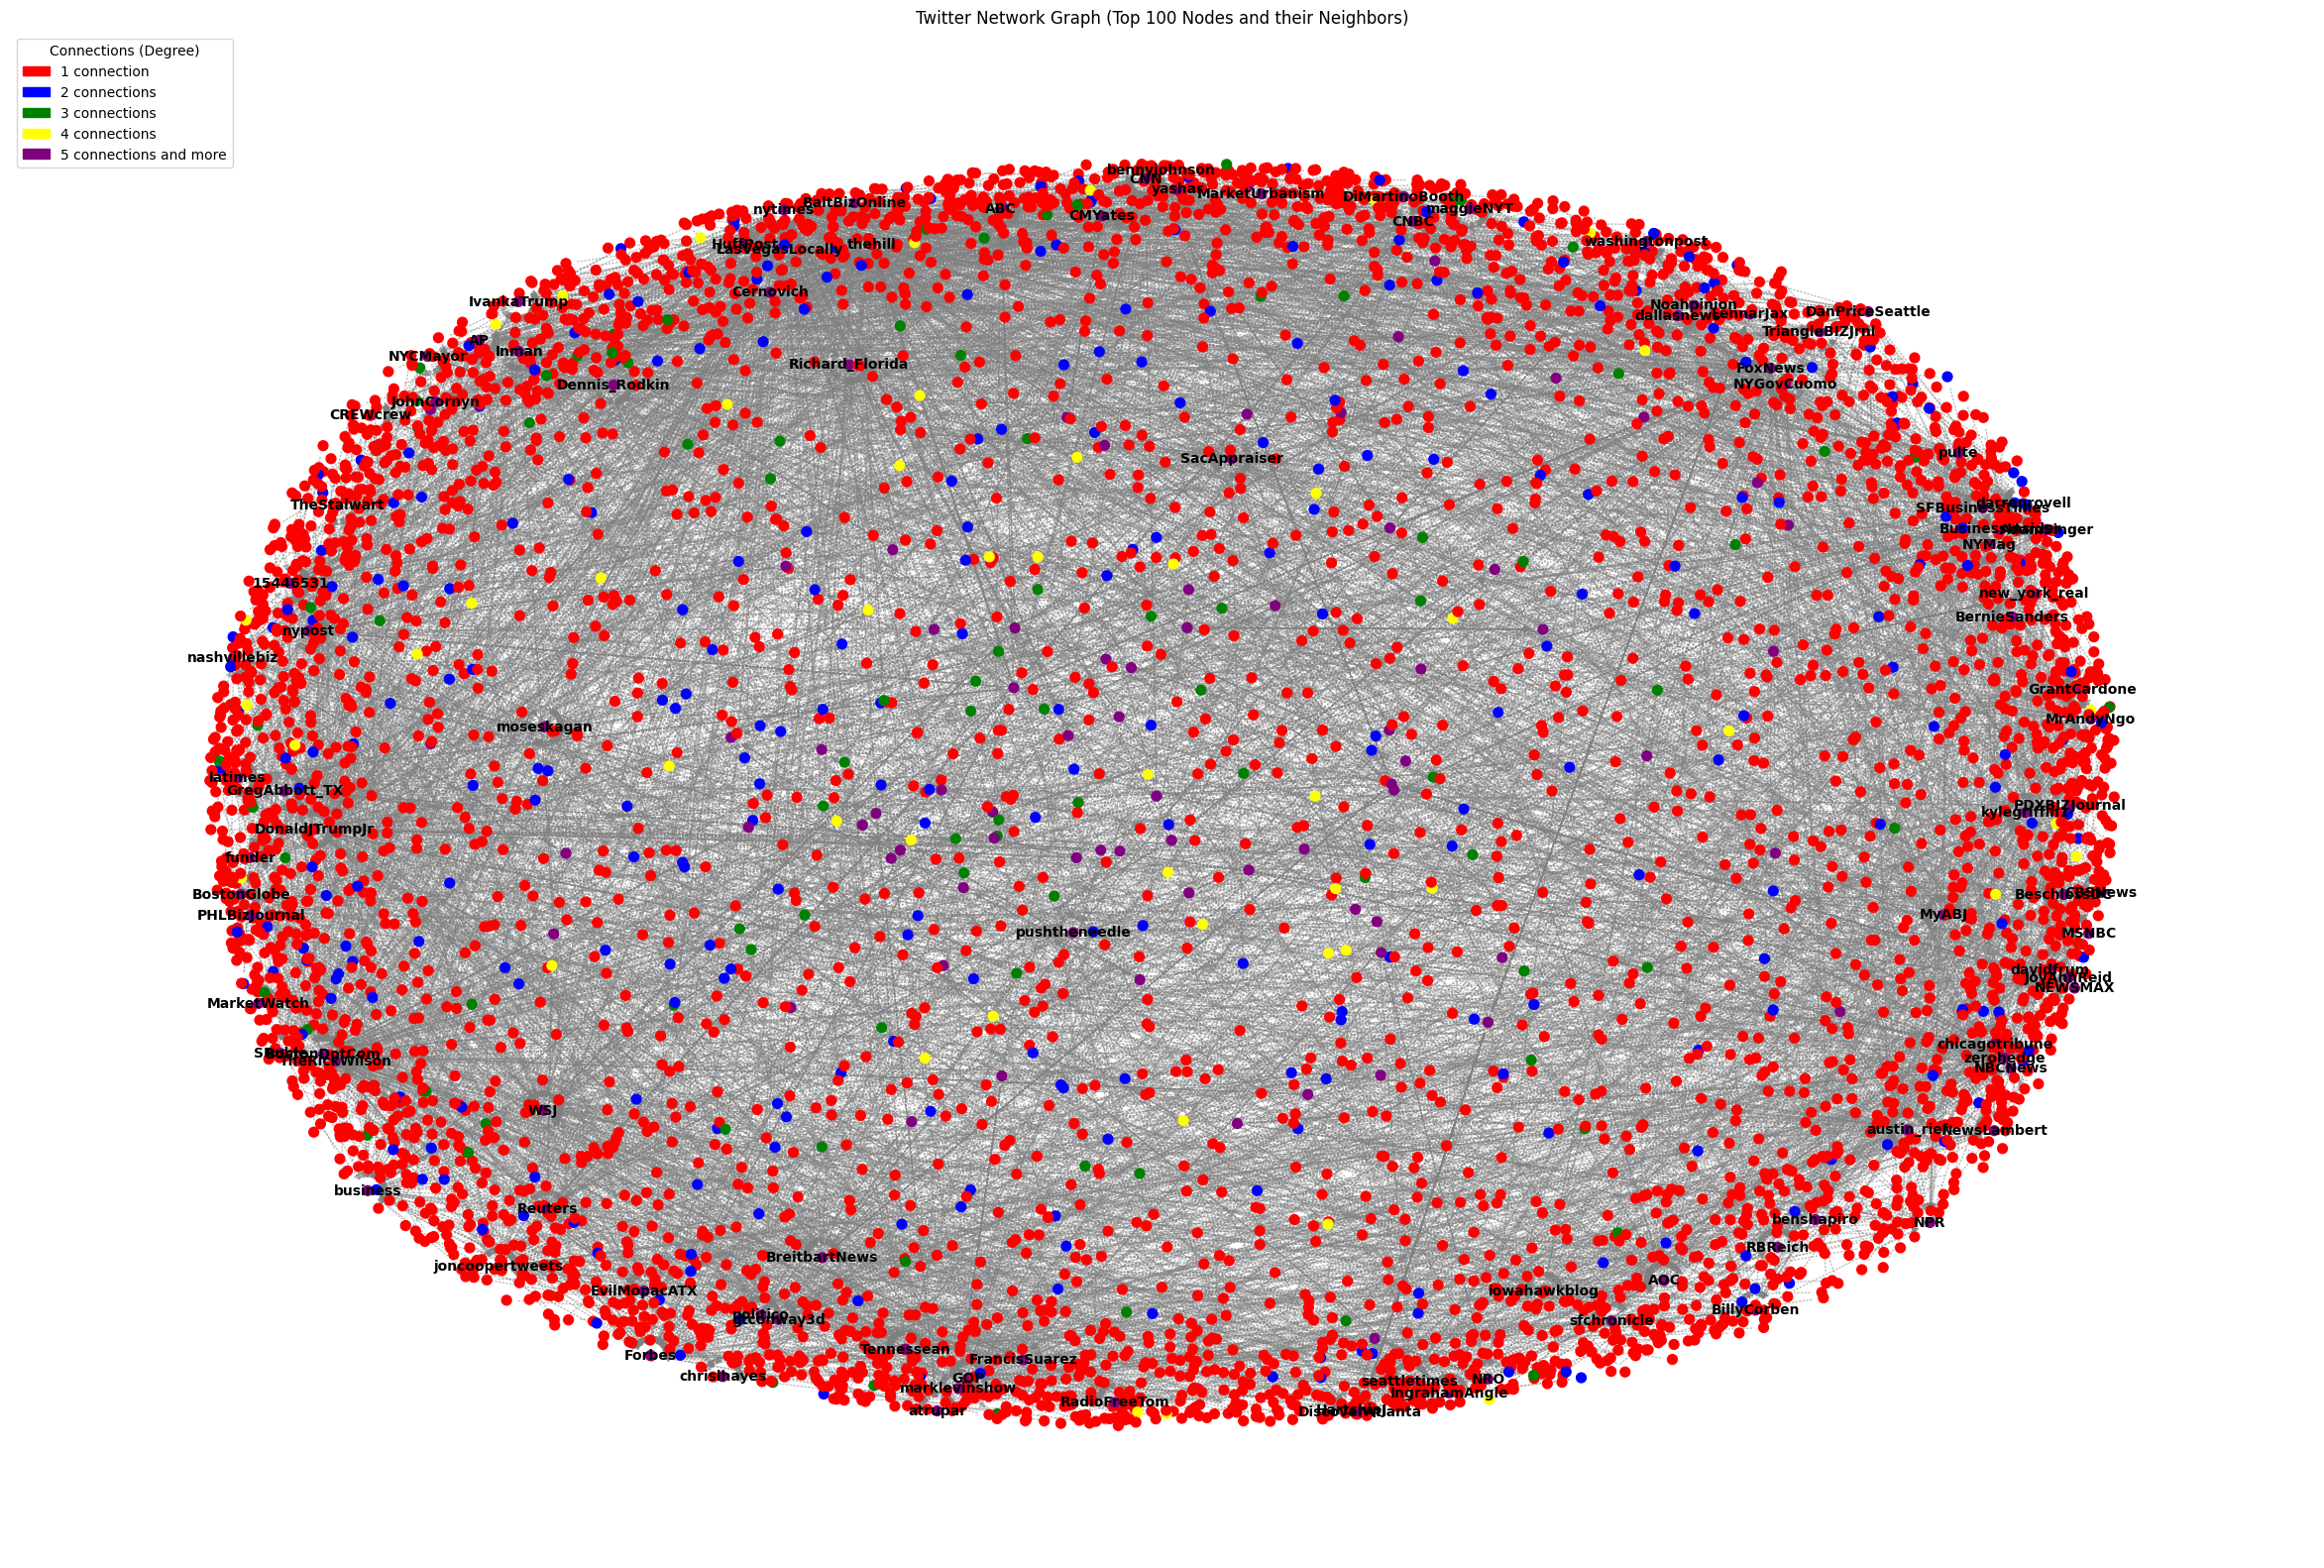

In [27]:
filtered_df = subset

G = nx.MultiDiGraph() # each pair between unique 2 nodes are counted as 1, repeated interaction not counted

# Add nodes for authors and in_reply_to_usernames
G.add_nodes_from(filtered_df['author_username'].unique(), node_type='author')
G.add_nodes_from(filtered_df['in_reply_to_username1'].unique(), node_type='in_reply_to')

# Add edges from DataFrame without iterating
G.add_edges_from(filtered_df[['author_username', 'in_reply_to_username1']].values)

#############################

# Get the top 100 nodes based on degree centrality
degree_centralities = nx.in_degree_centrality(G)
sorted_nodes = sorted(degree_centralities, key=degree_centralities.get, reverse=True)
top_100_nodes = sorted_nodes[:100]

# Get the predecessors of the top 100 nodes (users who responded to the top 100 nodes)
predecessor_nodes = set()
for node in top_100_nodes:
    predecessor_nodes.update(G.predecessors(node))

# Combine the top nodes and their predecessors
all_relevant_nodes = set(top_100_nodes).union(predecessor_nodes)

# Create a subgraph using these nodes
subG = G.subgraph(all_relevant_nodes)

# Calculate degree for each node in the subgraph
degrees = [degree for node, degree in subG.degree()]

# Determine node colors based on degree
node_degrees = dict(subG.degree())
colors = []
for node, degree in node_degrees.items():
    if degree == 1:
        colors.append('red')
    elif degree == 2:
        colors.append('blue')
    elif degree == 3:
        colors.append('green')
    elif degree == 4:
        colors.append('yellow')
    else:  # 5 and more
        colors.append('purple')

plt.figure(figsize=(30, 20), facecolor='white')

# Generate position with more space and iterations
pos = nx.spring_layout(subG, scale=2, k=0.3, iterations=50)

# Draw nodes and edges
nx.draw_networkx_nodes(subG, pos, node_size=50, node_color=colors)
nx.draw_networkx_edges(subG, pos, width=1, edge_color='gray', style='dotted', alpha=0.5)

# Label the top 100 nodes
top_100_labels = {node: node for node in top_100_nodes}
nx.draw_networkx_labels(subG, pos, labels=top_100_labels, font_size=10, font_color='black', font_weight='bold')

# Create custom legend
legend_colors = ['red', 'blue', 'green', 'yellow', 'purple']
legend_labels = [
    "1 connection",
    "2 connections",
    "3 connections",
    "4 connections",
    "5 connections and more"
]

patchList = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patchList, loc='upper left', title="Connections (Degree)")

plt.title("Twitter Network Graph (Top 100 Nodes and their Neighbors)")
plt.axis('off')
plt.show()


# Graph showing the network between Top Influencers

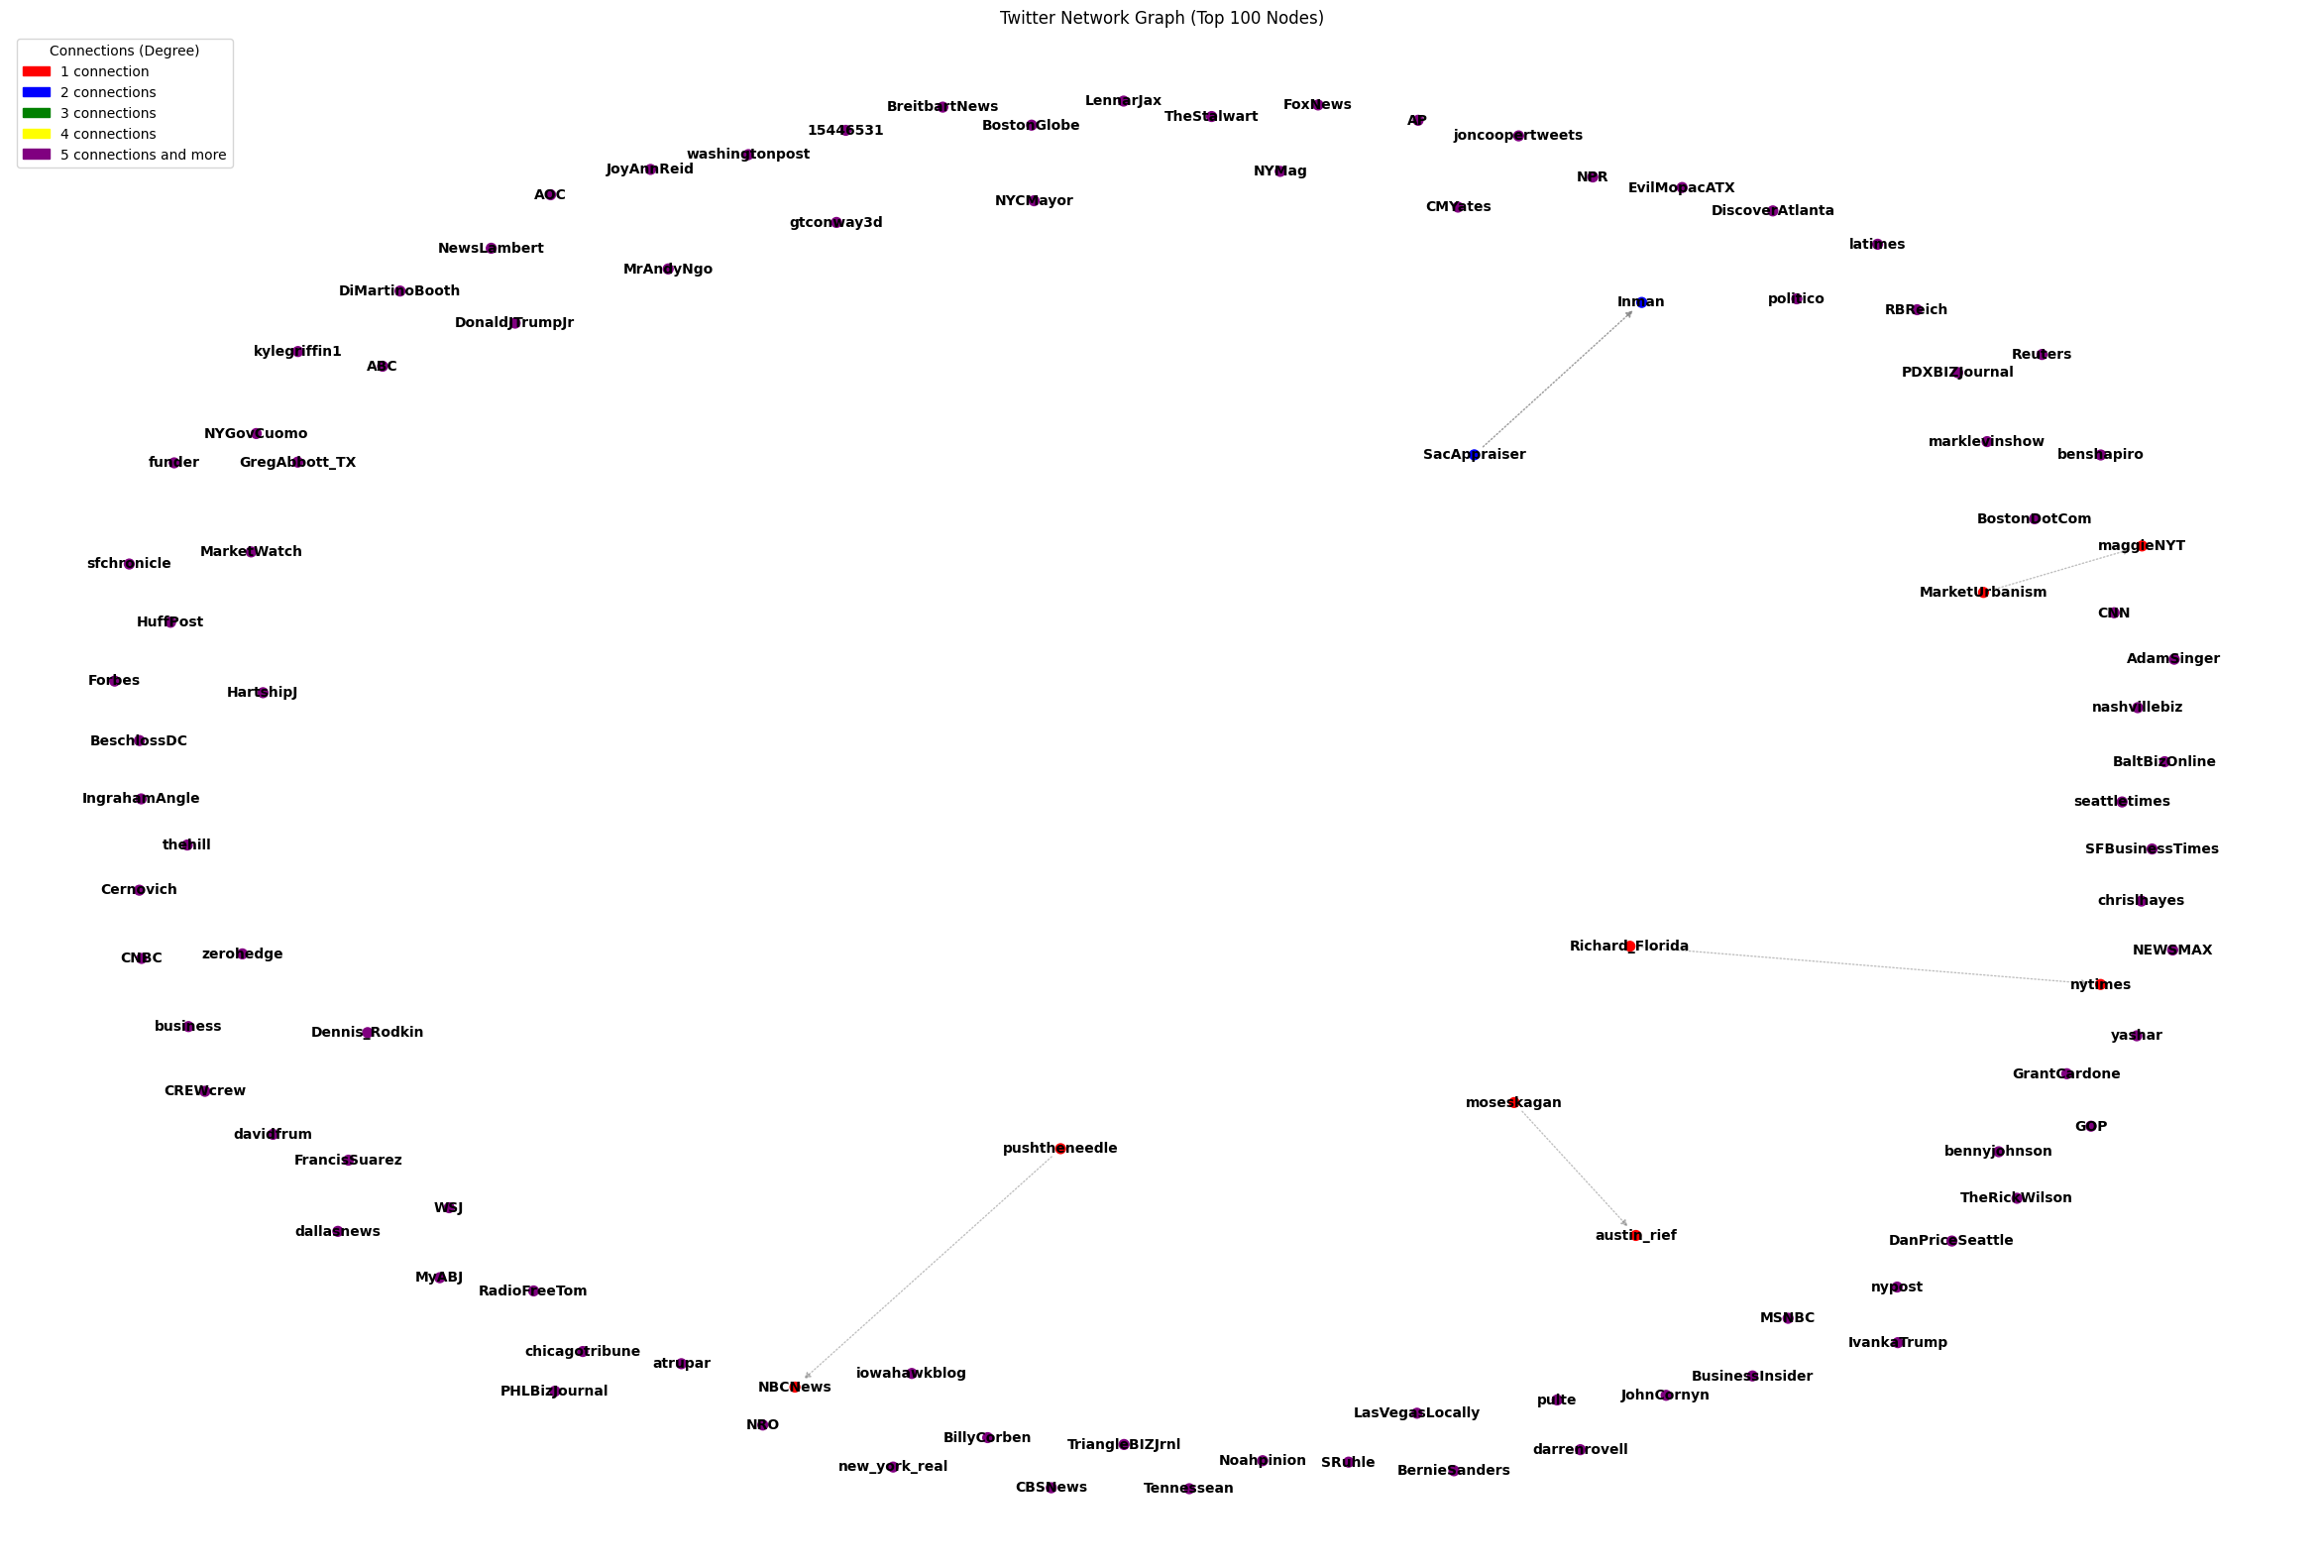

In [31]:
# ... [Your existing code for creating G and finding top_100_nodes] ...

# Create a subgraph using only the top 100 nodes
subG = G.subgraph(top_100_nodes)

# Calculate degree for each node in the subgraph
degrees = [degree for node, degree in subG.degree()]

# Determine node colors based on degree
node_degrees = dict(subG.degree())
colors = []
for node, degree in node_degrees.items():
    if degree == 1:
        colors.append('red')
    elif degree == 2:
        colors.append('blue')
    elif degree == 3:
        colors.append('green')
    elif degree == 4:
        colors.append('yellow')
    else:  # 5 and more
        colors.append('purple')

# Visualization
plt.figure(figsize=(30, 20), facecolor='white')

# Generate position with more space and iterations
pos = nx.spring_layout(subG, scale=2, k=0.3, iterations=50)

# Draw nodes and edges
nx.draw_networkx_nodes(subG, pos, node_size=50, node_color=colors)
nx.draw_networkx_edges(subG, pos, width=1, edge_color='gray', style='dotted', alpha=0.5)

# Label the top 100 nodes
top_100_labels = {node: node for node in top_100_nodes}
nx.draw_networkx_labels(subG, pos, labels=top_100_labels, font_size=10, font_color='black', font_weight='bold')

# Create custom legend
legend_colors = ['red', 'blue', 'green', 'yellow', 'purple']
legend_labels = [
    "1 connection",
    "2 connections",
    "3 connections",
    "4 connections",
    "5 connections and more"
]

patchList = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
plt.legend(handles=patchList, loc='upper left', title="Connections (Degree)")

plt.title("Twitter Network Graph (Top 100 Nodes)")
plt.axis('off')
plt.show()
